In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import constants, units
from astropy.coordinates import Angle
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import pandas as pd
import os
#import dustmaps

In [2]:
rootdir = '/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/'

In [3]:
plt.style.use('/Users/thepoetoftwilight/Documents/CUBS/Code/science.mplstyle')

# CUBEX

Load in the MUSE FITS file

In [4]:
muse_fits = fits.open(rootdir + 'MUSE/COMBINED_CUBE_MED_FINAL_vac.fits')

In [5]:
muse_fits.info()

Filename: /Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/MUSE/COMBINED_CUBE_MED_FINAL_vac.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1211   ()      
  1  DATA          1 ImageHDU        42   (337, 319, 3682)   float32   
  2  STAT          1 ImageHDU        43   (337, 319, 3682)   float32   


In [6]:
data_hdu = muse_fits[1]
var_hdu = muse_fits[2]

Extract the MUSE cube as a 3-D array

In [7]:
spec_cube = data_hdu.data.copy()
var_cube = var_hdu.data.copy()

In [8]:
spec_cube.shape, var_cube.shape

((3682, 319, 337), (3682, 319, 337))

Extract the wavelength array

In [9]:
wav_0 = data_hdu.header['CRVAL3']
del_wav = data_hdu.header['CD3_3']

In [10]:
wav_0, del_wav

(4751.284541786687, 1.25)

In [11]:
wav_arr_cubex = np.arange(wav_0, wav_0 + (spec_cube.shape[0]-1)*del_wav, del_wav)

In [12]:
len(wav_arr_cubex)

3682

In [13]:
wav_0, del_wav, (spec_cube.shape[0]-1)

(4751.284541786687, 1.25, 3681)

Define images

In [14]:
img_pseudo_g = np.nansum(spec_cube[np.where((wav_arr_cubex>=4800)&(wav_arr_cubex<=5800))[0],:,:], axis=0)
img_pseudo_r = np.nansum(spec_cube[np.where((wav_arr_cubex>=6000)&(wav_arr_cubex<=7500))[0],:,:], axis=0)
img_pseudo_i = np.nansum(spec_cube[np.where((wav_arr_cubex>=7500)&(wav_arr_cubex<=9000))[0],:,:], axis=0)

## pseudo-g

In [15]:
x0, y0 = 109, 248
x = np.arange(spec_cube.shape[1])
y = np.arange(spec_cube.shape[2])
X,Y = np.meshgrid(x,y)
A = 45*np.pi/180
gal_y, gal_x = np.where((((X-x0)*np.cos(A)+(Y-y0)*np.sin(A))/3.5)**2+(((X-x0)*np.sin(A)-(Y-y0)*np.cos(A))/2.5)**2<1)

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6723/2701290587.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6723/2701290587.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',


(228.0, 268.0)

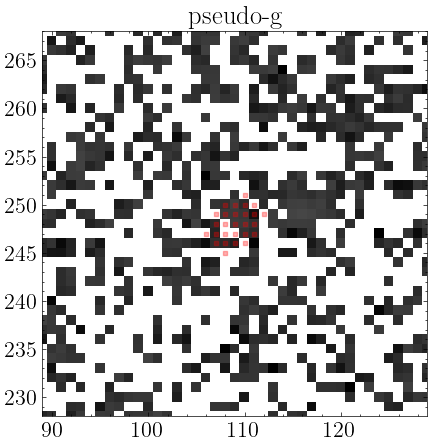

In [16]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_g), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20

ax.set_title('pseudo-g')
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-r

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6723/2908512815.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6723/2908512815.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',


(228.0, 268.0)

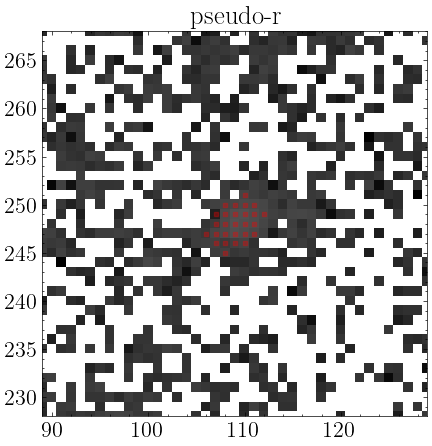

In [17]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_r), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)
dwin = 20

ax.set_title('pseudo-r')
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-i

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6723/1593997645.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6723/1593997645.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',


(228.0, 268.0)

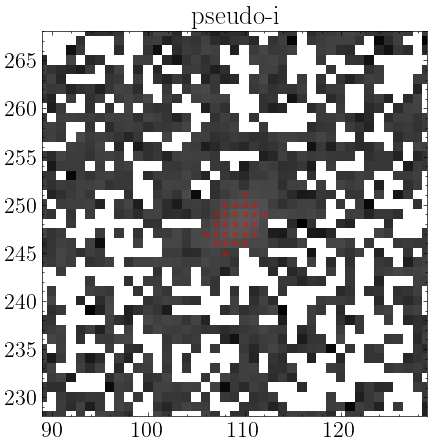

In [18]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_i), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)
dwin = 20

ax.set_title('pseudo-i')
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

In [19]:
spec_gal_cubex = np.zeros(len(wav_arr_cubex))
err_gal_cubex = np.zeros(len(wav_arr_cubex))

In [20]:
spec_stack = np.zeros((len(gal_x), len(wav_arr_cubex)))
var_stack = np.zeros((len(gal_x), len(wav_arr_cubex)))

for j in range(len(gal_x)):

    x = gal_x[j]
    y = gal_y[j]

    spec_stack[j,:] = spec_cube[:,y,x]
    var_stack[j,:] = var_cube[:,y,x]

spec_gal_cubex = np.nansum(spec_stack, axis=0)
err_gal_cubex = np.sqrt(np.nansum(var_stack, axis=0))

## 4000Å break

In [21]:
#np.savetxt('/Users/thepoetoftwilight/Desktop/z_104_gal_spec.dat', np.array([wav_arr_cubex, spec_gal_cubex, err_gal_cubex]).T)

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

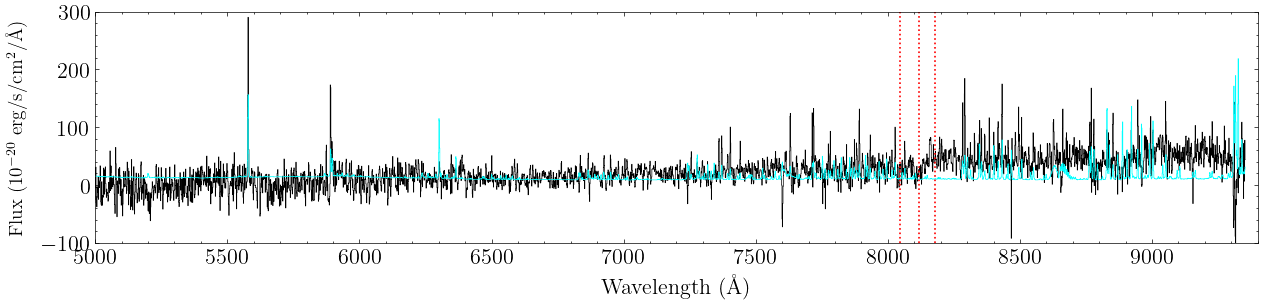

In [22]:
fig, ax = plt.subplots(1, figsize=(15,3))

ax.step(wav_arr_cubex, spec_gal_cubex, where='mid', lw=.5)
ax.step(wav_arr_cubex, err_gal_cubex, where='mid', color='cyan', lw=.5)

ax.axvline(3934.78*(1+1.0448), linestyle=':', color='red', lw=1.2)
ax.axvline(3969.59*(1+1.0448), linestyle=':', color='red', lw=1.2)

ax.axvline(4000*(1+1.0448), linestyle=':', color='red', lw=1.2)


ax.set_xlim(5000, 9400)
ax.set_ylim(-100, 300)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

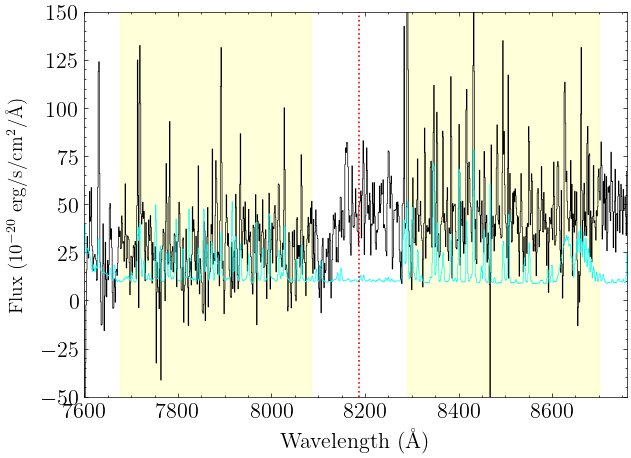

In [23]:
fig, ax = plt.subplots(1, figsize=(7,5))

ax.step(wav_arr_cubex, spec_gal_cubex, where='mid', lw=.5)
ax.step(wav_arr_cubex, err_gal_cubex, where='mid', color='cyan', lw=.5)

#ax.axvline(3934.78*(1+1.047), linestyle=':', color='red', lw=1.2)
#ax.axvline(3969.59*(1+1.047), linestyle=':', color='red', lw=1.2)

ax.axvline(4000*(1+1.047), linestyle=':', color='red', lw=1.2)

ax.axvspan(3750*(1+1.047),3950*(1+1.047), color='yellow', alpha=.15)
ax.axvspan(4050*(1+1.047),4250*(1+1.047), color='yellow', alpha=.15)

#ax.axhline(23, linestyle='--', color='orange')
#ax.axhline(42, linestyle='--', color='orange')

ax.set_xlim(7600, 8760)
#ax.set_ylim(-50, 150)
ax.set_ylim(-50,150)
ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

In [97]:
idx1 = (wav_arr_cubex>3750*(1+1.047))&(wav_arr_cubex<3950*(1+1.047))
f1 = np.nansum(wav_arr_cubex[idx1]**2*spec_gal_cubex[idx1])
s1 = np.sqrt(np.nansum(wav_arr_cubex[idx1]**4*err_gal_cubex[idx1]**2))

idx2 = (wav_arr_cubex>4050*(1+1.047))&(wav_arr_cubex<4250*(1+1.047))
f2 = np.nansum(wav_arr_cubex[idx2]**2*spec_gal_cubex[idx2])
s2 = np.sqrt(np.nansum(wav_arr_cubex[idx2]**4*err_gal_cubex[idx2]**2))

In [98]:
D = f2/f1
dD = D*np.sqrt((s1/f1)**2 + (s2/f2)**2)

In [100]:
D, dD

(1.8468974101165283, 0.08209662915236028)

## Redshift-fit

In [101]:
eigenspec_df = pd.read_csv('/Users/thepoetoftwilight/Documents/CUBS/Data/Eigenspectra/eigen_galaxy_Bolton2012.csv')

In [102]:
wav_eigen = eigenspec_df['wav']
c1 = eigenspec_df['c1']
c2 = eigenspec_df['c2']
c3 = eigenspec_df['c3']
c4 = eigenspec_df['c4']

In [103]:
def z_shift_eigen(z, wav_arr):
    
    wav_eigen_shift = wav_eigen*(1+z)
    
    gal_ind = (wav_eigen_shift>=wav_arr[0])&(wav_eigen_shift<=wav_arr[-1])
    wav_eigen_shift_gal = wav_eigen_shift[gal_ind]
    
    c1_gal = c1[gal_ind]
    c1_gal_interp = np.interp(wav_arr, wav_eigen_shift_gal, c1_gal)

    c2_gal = c2[gal_ind]
    c2_gal_interp = np.interp(wav_arr, wav_eigen_shift_gal, c2_gal)
    
    c3_gal = c3[gal_ind]
    c3_gal_interp = np.interp(wav_arr, wav_eigen_shift_gal, c3_gal)

    c4_gal = c4[gal_ind]
    c4_gal_interp = np.interp(wav_arr, wav_eigen_shift_gal, c4_gal)
    
    return c1_gal_interp, c2_gal_interp, c3_gal_interp, c4_gal_interp

In [104]:
def best_model(c1, c2, c3, c4, y, y_err):

    A11 = np.sum((c1/y_err)**2)
    A12 = np.sum(c1*c2/y_err**2)
    A13 = np.sum(c1*c3/y_err**2)
    A14 = np.sum(c1*c4/y_err**2)
    
    A21 = np.sum(c2*c1/y_err**2)
    A22 = np.sum((c2/y_err)**2)
    A23 = np.sum(c2*c3/y_err**2)
    A24 = np.sum(c2*c4/y_err**2)
    
    A31 = np.sum(c3*c1/y_err**2)
    A32 = np.sum(c3*c2/y_err**2)
    A33 = np.sum((c3/y_err)**2)
    A34 = np.sum(c3*c4/y_err**2)
    
    A41 = np.sum(c4*c1/y_err**2)
    A42 = np.sum(c4*c2/y_err**2)
    A43 = np.sum(c4*c3/y_err**2)
    A44 = np.sum((c4/y_err)**2)
    
    b1 = np.sum(y*c1/y_err**2)
    b2 = np.sum(y*c2/y_err**2)
    b3 = np.sum(y*c3/y_err**2)
    b4 = np.sum(y*c4/y_err**2)
    
    A_mat = np.array([[A11, A12, A13, A14],[A21, A22, A23, A24],[A31, A32, A33, A34],[A41, A42, A43, A44]])
    b_vec = np.array([b1, b2, b3, b4])
    
    x_vec = np.linalg.inv(A_mat)@b_vec
    
    a = x_vec[0]
    b = x_vec[1]
    c = x_vec[2]
    d = x_vec[3]

    return a, b, c, d

In [110]:
def eval_red_chi_sq(y_hat, y, y_err, dof):
    
    return np.sum(((y-y_hat)/y_err)**2)/(len(y)-dof)

In [147]:
z_arr = np.arange(0.0,2,1e-4)
red_chi_sq_arr = np.zeros(len(z_arr))

In [148]:
model_params = np.zeros((len(z_arr), 4))

In [149]:
idx = ~np.isnan(spec_gal_cubex)

In [150]:
for i in range(len(z_arr)):
    
    z = z_arr[i]
    
    c1_shift, c2_shift, c3_shift, c4_shift = z_shift_eigen(z, wav_arr_cubex[idx][20:-20])
    
    a, b, c, d = best_model(c1_shift, c2_shift, c3_shift, c4_shift, 
                            spec_gal_cubex[idx][20:-20], err_gal_cubex[idx][20:-20])
    
    model_params[i,0] = a
    model_params[i,1] = b
    model_params[i,2] = c
    model_params[i,3] = d 
    
    red_chi_sq = eval_red_chi_sq(a*c1_shift+b*c2_shift+c*c3_shift+d*c4_shift, 
                                        spec_gal_cubex[idx][20:-20], err_gal_cubex[idx][20:-20], model_params.shape[1])
    
    red_chi_sq_arr[i] = red_chi_sq
    
    #print(a, b, c, d, red_chi_sq)

Text(0, 0.5, '$\\chi^2_\\mathrm{red}$')

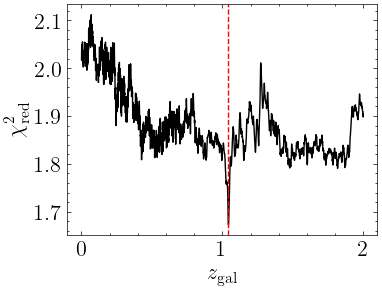

In [151]:
fig, ax = plt.subplots(1, figsize=(4,3))

ax.plot(z_arr, red_chi_sq_arr)
ax.axvline(1.0426, linestyle='--', color='red')

ax.set_xlabel(r'$z_\mathrm{gal}$')
ax.set_ylabel(r'$\chi^2_\mathrm{red}$')

In [152]:
z = z_arr[np.argmin(red_chi_sq_arr)]
c1_shift, c2_shift, c3_shift, c4_shift = z_shift_eigen(z, wav_arr_cubex)

In [153]:
z

1.0426

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

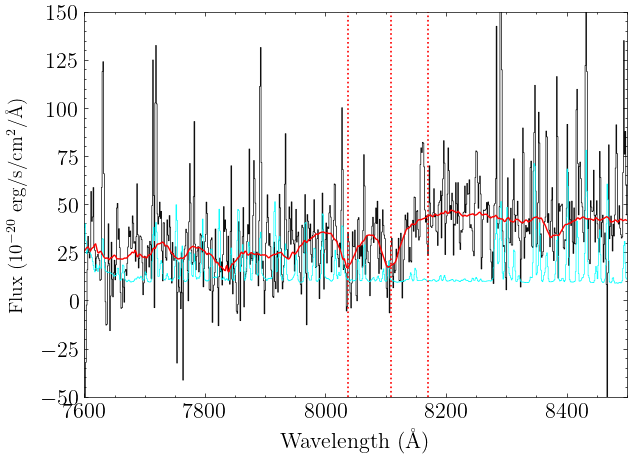

In [140]:
fig, ax = plt.subplots(1, figsize=(7,5))

ax.step(wav_arr_cubex, spec_gal_cubex, where='mid', lw=.5)
ax.step(wav_arr_cubex, err_gal_cubex, where='mid', color='cyan', lw=.5)

ax.axvline(3934.78*(1+1.0425), linestyle=':', color='red', lw=1.2)
ax.axvline(3969.59*(1+1.0425), linestyle=':', color='red', lw=1.2)

ax.axvline(4000*(1+1.0425), linestyle=':', color='red', lw=1.2)

#ax.axvspan(3750*(1+1.047),3950*(1+1.047), color='yellow', alpha=.15)
#ax.axvspan(4050*(1+1.047),4250*(1+1.047), color='yellow', alpha=.15)

ax.plot(wav_arr_cubex, model_params[np.argmin(red_chi_sq_arr),0]*c1_shift + model_params[np.argmin(red_chi_sq_arr),1]*c2_shift + model_params[np.argmin(red_chi_sq_arr),2]*c3_shift + model_params[np.argmin(red_chi_sq_arr),3]*c4_shift, lw=1, color='red')

#ax.axhline(23, linestyle='--', color='orange')
#ax.axhline(42, linestyle='--', color='orange')

ax.set_xlim(7600, 8500)
#ax.set_ylim(-50, 150)
ax.set_ylim(-50,150)
ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

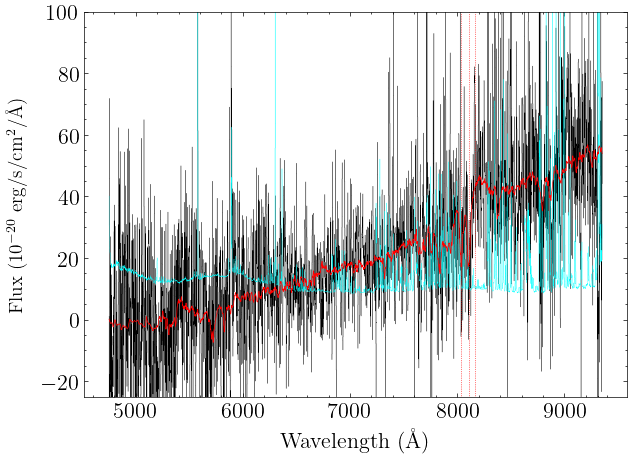

In [162]:
fig, ax = plt.subplots(1, figsize=(7,5))

ax.step(wav_arr_cubex, spec_gal_cubex, where='mid', lw=.2)
ax.step(wav_arr_cubex, err_gal_cubex, where='mid', color='cyan', lw=.2)

ax.axvline(3934.78*(1+1.0425), linestyle=':', color='red', lw=.5)
ax.axvline(3969.59*(1+1.0425), linestyle=':', color='red', lw=.5)

ax.axvline(4000*(1+1.0425), linestyle=':', color='red', lw=.5)

#ax.axvspan(3750*(1+1.047),3950*(1+1.047), color='yellow', alpha=.15)
#ax.axvspan(4050*(1+1.047),4250*(1+1.047), color='yellow', alpha=.15)

ax.plot(wav_arr_cubex, model_params[np.argmin(red_chi_sq_arr),0]*c1_shift + model_params[np.argmin(red_chi_sq_arr),1]*c2_shift + model_params[np.argmin(red_chi_sq_arr),2]*c3_shift + model_params[np.argmin(red_chi_sq_arr),3]*c4_shift, lw=.5, color='red')

#ax.axhline(23, linestyle='--', color='orange')
#ax.axhline(42, linestyle='--', color='orange')

#ax.set_xlim(7600, 8500)
#ax.set_ylim(-50, 150)
ax.set_ylim(-25,100)
ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

# ESO

Load in the MUSE FITS file

In [27]:
muse_fits = fits.open(rootdir + 'MUSE/PG1522+101_eso_coadd_nosky.fits')

In [28]:
muse_fits.info()

Filename: /Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/MUSE/PG1522+101_eso_coadd_nosky.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1211   ()      
  1  DATA          1 ImageHDU        38   (337, 335, 3679)   float32   
  2  STAT          1 ImageHDU        38   (337, 335, 3679)   float32   


In [29]:
data_hdu = muse_fits[1]
var_hdu = muse_fits[2]

Extract the MUSE cube as a 3-D array

In [30]:
spec_cube = data_hdu.data.copy()
var_cube = var_hdu.data.copy()

In [31]:
spec_cube.shape, var_cube.shape

((3679, 335, 337), (3679, 335, 337))

Extract the wavelength array

In [32]:
wav_0 = data_hdu.header['CRVAL3']
del_wav = data_hdu.header['CD3_3']

In [33]:
wav_0, del_wav

(4750.1, 1.25)

In [34]:
wav_arr_eso = np.arange(wav_0, wav_0 + spec_cube.shape[0]*del_wav, del_wav)

In [35]:
wav_arr_cubex[0], wav_arr_eso[0]

(4751.284541786687, 4750.1)

In [36]:
wav_0, del_wav, (spec_cube.shape[0]-1)

(4750.1, 1.25, 3678)

In [37]:
len(wav_arr_eso)

3679

Define images

In [38]:
img_pseudo_g = np.nansum(spec_cube[np.where((wav_arr_eso>=4800)&(wav_arr_eso<=5800))[0],:,:], axis=0)
img_pseudo_r = np.nansum(spec_cube[np.where((wav_arr_eso>=6000)&(wav_arr_eso<=7500))[0],:,:], axis=0)
img_pseudo_i = np.nansum(spec_cube[np.where((wav_arr_eso>=7500)&(wav_arr_eso<=9000))[0],:,:], axis=0)

## pseudo-g

In [39]:
x0, y0 = 110, 253
x = np.arange(spec_cube.shape[1])
y = np.arange(spec_cube.shape[2])
X,Y = np.meshgrid(x,y)
A = 45*np.pi/180
gal_y, gal_x = np.where((((X-x0)*np.cos(A)+(Y-y0)*np.sin(A))/3.5)**2+(((X-x0)*np.sin(A)-(Y-y0)*np.cos(A))/2.5)**2<1)

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6723/834528210.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',


(233.0, 273.0)

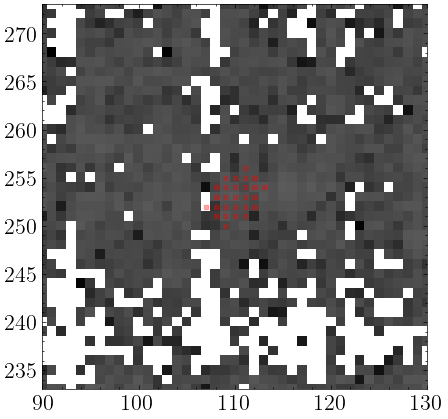

In [40]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_g), origin='lower',
          vmin=0, vmax=8, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-r

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6723/4213588627.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',


(233.0, 273.0)

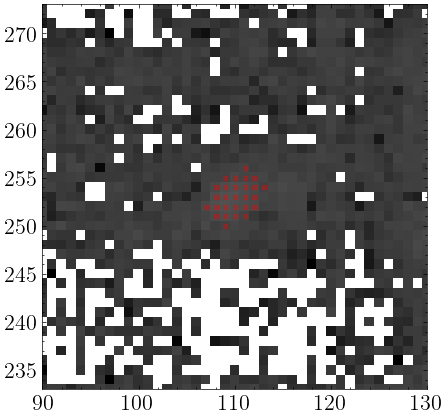

In [41]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_r), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)
dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-i

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6723/2411518768.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',


(233.0, 273.0)

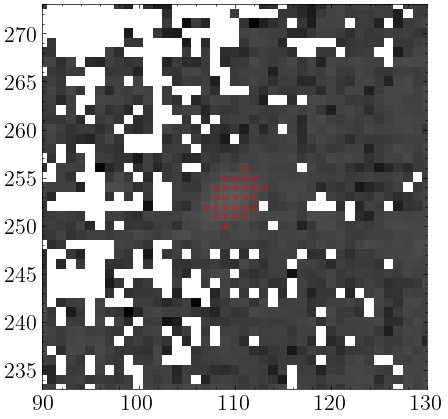

In [42]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_i), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)
dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

In [43]:
spec_gal_eso = np.zeros(len(wav_arr_eso))
err_gal_eso = np.zeros(len(wav_arr_eso))

In [44]:
len(gal_x)

27

In [45]:
spec_stack = np.zeros((len(gal_x), len(wav_arr_eso)))
var_stack = np.zeros((len(gal_x), len(wav_arr_eso)))

for j in range(len(gal_x)):

    x = gal_x[j]
    y = gal_y[j]

    spec_stack[j,:] = spec_cube[:,y,x]
    var_stack[j,:] = var_cube[:,y,x]

spec_gal_eso = np.nansum(spec_stack, axis=0)
err_gal_eso = np.sqrt(np.nansum(var_stack, axis=0))

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

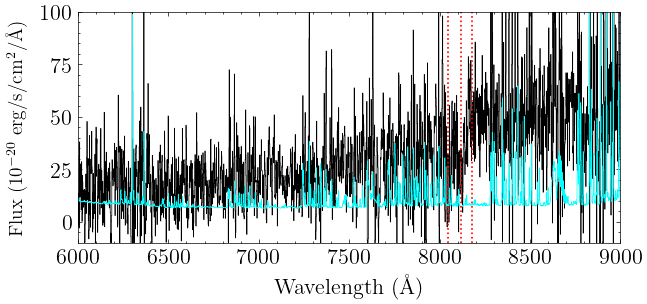

In [46]:
fig, ax = plt.subplots(1, figsize=(7,3))

ax.step(wav_arr_eso, spec_gal_eso, where='mid', lw=.5)
ax.step(wav_arr_eso, err_gal_eso, where='mid', color='cyan', lw=.5)

ax.axvline(3934.78*(1+1.0448), linestyle=':', color='red', lw=1.2)
ax.axvline(3969.59*(1+1.0448), linestyle=':', color='red', lw=1.2)

ax.axvline(4000*(1+1.0448), linestyle=':', color='red', lw=1.2)


ax.set_xlim(6000, 9000)
ax.set_ylim(-10, 100)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

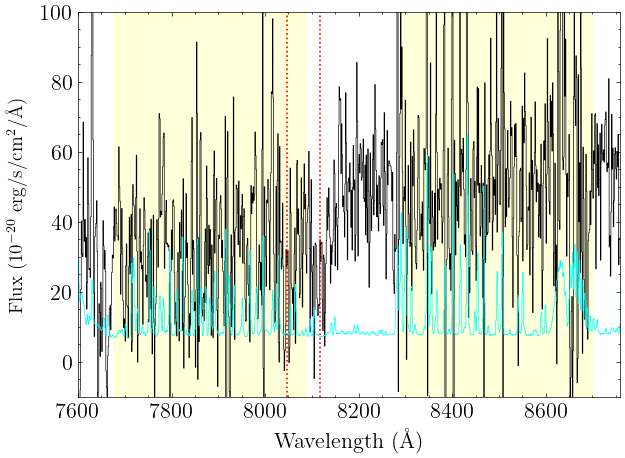

In [47]:
fig, ax = plt.subplots(1, figsize=(7,5))

ax.step(wav_arr_eso, spec_gal_eso, where='mid', lw=.5)
ax.step(wav_arr_eso, err_gal_eso, where='mid', color='cyan', lw=.5)

ax.axvline(3934.78*(1+1.0449), linestyle=':', color='red', lw=1.2)
ax.axvline(3969.59*(1+1.0449), linestyle=':', color='red', lw=1.2)

#ax.axvline(4000*(1+1.047), linestyle=':', color='red', lw=1.2)

ax.axvspan(3750*(1+1.047),3950*(1+1.047), color='yellow', alpha=.15)
ax.axvspan(4050*(1+1.047),4250*(1+1.047), color='yellow', alpha=.15)

#ax.axhline(23, linestyle='--', color='orange')
#ax.axhline(42, linestyle='--', color='orange')

ax.set_xlim(7600, 8760)
ax.set_ylim(-10,100)
ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

In [48]:
idx1 = (wav_arr_eso>3750*(1+1.047))&(wav_arr_eso<3950*(1+1.047))
f1 = np.mean(wav_arr_eso[idx1]**2*spec_gal_eso[idx1])
s1 = np.std(wav_arr_eso[idx1]**2*spec_gal_eso[idx1])

idx2 = (wav_arr_eso>4050*(1+1.047))&(wav_arr_eso<4250*(1+1.047))
f2 = np.mean(wav_arr_eso[idx2]**2*spec_gal_eso[idx2])
s2 = np.std(wav_arr_eso[idx2]**2*spec_gal_eso[idx2])

In [49]:
D = f2/f1
dD = D*np.sqrt((s1/f1)**2 + (s2/f2)**2)

In [50]:
D, dD

(1.8605310196913702, 1.7176241382593913)

# ZAP

Load in the MUSE FITS file

In [51]:
muse_fits = fits.open(rootdir + 'MUSE/PG1522+101_ESO-DEEP_ZAP.fits')

In [52]:
muse_fits.info()

Filename: /Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/MUSE/PG1522+101_ESO-DEEP_ZAP.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1350   ()      
  1  DATA          1 ImageHDU        52   (337, 335, 3682)   float32   
  2  STAT          1 ImageHDU        43   (337, 335, 3682)   float32   


In [53]:
data_hdu = muse_fits[1]
var_hdu = muse_fits[2]

Extract the MUSE cube as a 3-D array

In [54]:
spec_cube = data_hdu.data.copy()
var_cube = var_hdu.data.copy()

In [55]:
spec_cube.shape, var_cube.shape

((3682, 335, 337), (3682, 335, 337))

Extract the wavelength array

In [56]:
wav_0 = data_hdu.header['CRVAL3']
del_wav = data_hdu.header['CD3_3']

In [57]:
wav_0, del_wav

(4749.9560546875, 1.25)

In [58]:
wav_arr_zap = np.arange(wav_0, wav_0 + spec_cube.shape[0]*del_wav, del_wav)

In [59]:
wav_arr_cubex[0], wav_arr_zap[0]

(4751.284541786687, 4749.9560546875)

In [60]:
wav_0, del_wav, (spec_cube.shape[0]-1)

(4749.9560546875, 1.25, 3681)

In [61]:
len(wav_arr_zap)

3682

Define images

In [64]:
img_pseudo_g = np.nansum(spec_cube[np.where((wav_arr_zap>=4800)&(wav_arr_zap<=5800))[0],:,:], axis=0)
img_pseudo_r = np.nansum(spec_cube[np.where((wav_arr_zap>=6000)&(wav_arr_zap<=7500))[0],:,:], axis=0)
img_pseudo_i = np.nansum(spec_cube[np.where((wav_arr_zap>=7500)&(wav_arr_zap<=9000))[0],:,:], axis=0)

## pseudo-g

In [65]:
x0, y0 = 110, 253
x = np.arange(spec_cube.shape[1])
y = np.arange(spec_cube.shape[2])
X,Y = np.meshgrid(x,y)
A = 45*np.pi/180
gal_y, gal_x = np.where((((X-x0)*np.cos(A)+(Y-y0)*np.sin(A))/3.5)**2+(((X-x0)*np.sin(A)-(Y-y0)*np.cos(A))/2.5)**2<1)

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6723/834528210.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6723/834528210.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_g), origin='lower',


(233.0, 273.0)

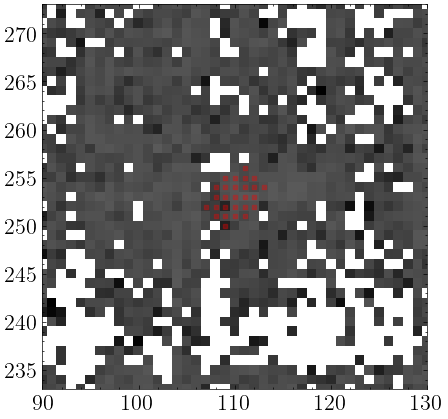

In [66]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_g), origin='lower',
          vmin=0, vmax=8, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)

dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-r

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6723/4213588627.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6723/4213588627.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_r), origin='lower',


(233.0, 273.0)

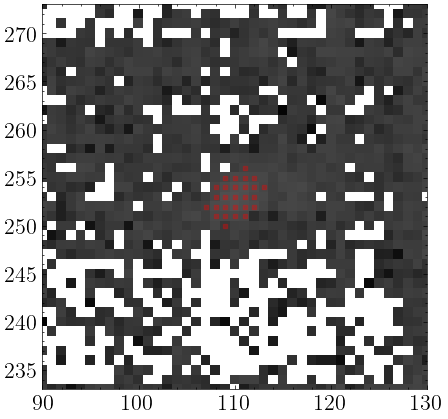

In [67]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_r), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)
dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

## pseudo-i

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6723/2411518768.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_6723/2411518768.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img_pseudo_i), origin='lower',


(233.0, 273.0)

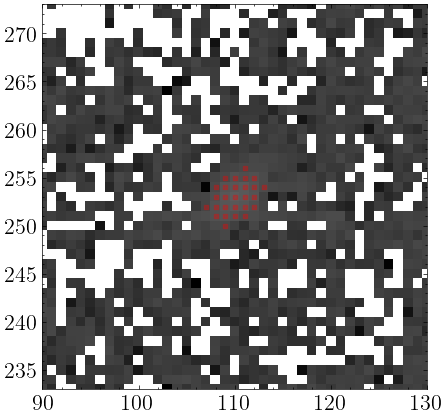

In [68]:
fig, ax = plt.subplots(1, figsize=(5,5))

plt.imshow(np.log10(img_pseudo_i), origin='lower',
          vmin=0, vmax=10, cmap='gray')

ax.scatter(gal_x, gal_y, marker='s', 
           color='red', s=10, alpha=.3)
dwin = 20
ax.set_xlim(x0-dwin,x0+dwin)
ax.set_ylim(y0-dwin,y0+dwin)

In [69]:
spec_gal_zap = np.zeros(len(wav_arr_zap))
err_gal_zap = np.zeros(len(wav_arr_zap))

In [70]:
len(gal_x)

27

In [71]:
spec_stack = np.zeros((len(gal_x), len(wav_arr_zap)))
var_stack = np.zeros((len(gal_x), len(wav_arr_zap)))

for j in range(len(gal_x)):

    x = gal_x[j]
    y = gal_y[j]

    spec_stack[j,:] = spec_cube[:,y,x]
    var_stack[j,:] = var_cube[:,y,x]

spec_gal_zap = np.nansum(spec_stack, axis=0)
err_gal_zap = np.sqrt(np.nansum(var_stack, axis=0))

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

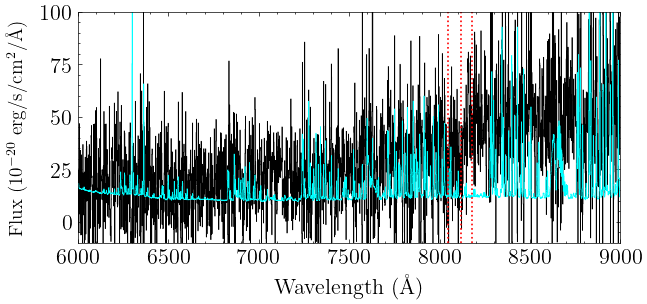

In [72]:
fig, ax = plt.subplots(1, figsize=(7,3))

ax.step(wav_arr_zap, spec_gal_zap, where='mid', lw=.5)
ax.step(wav_arr_zap, err_gal_zap, where='mid', color='cyan', lw=.5)

ax.axvline(3934.78*(1+1.0448), linestyle=':', color='red', lw=1.2)
ax.axvline(3969.59*(1+1.0448), linestyle=':', color='red', lw=1.2)

ax.axvline(4000*(1+1.0448), linestyle=':', color='red', lw=1.2)


ax.set_xlim(6000, 9000)
ax.set_ylim(-10, 100)

ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

Text(0, 0.5, 'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)')

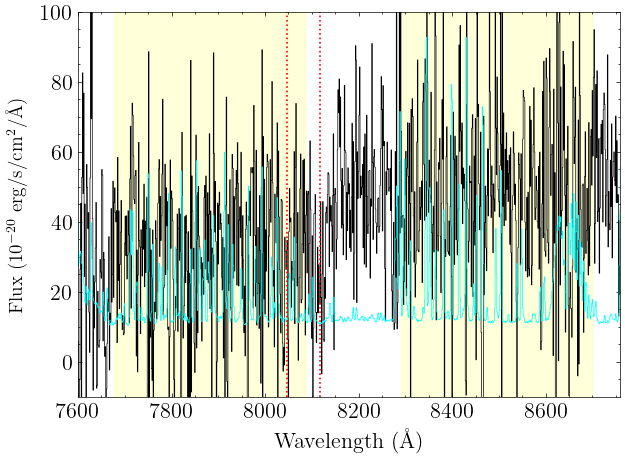

In [73]:
fig, ax = plt.subplots(1, figsize=(7,5))

ax.step(wav_arr_zap, spec_gal_zap, where='mid', lw=.5)
ax.step(wav_arr_zap, err_gal_zap, where='mid', color='cyan', lw=.5)

ax.axvline(3934.78*(1+1.0449), linestyle=':', color='red', lw=1.2)
ax.axvline(3969.59*(1+1.0449), linestyle=':', color='red', lw=1.2)

#ax.axvline(4000*(1+1.047), linestyle=':', color='red', lw=1.2)

ax.axvspan(3750*(1+1.047),3950*(1+1.047), color='yellow', alpha=.15)
ax.axvspan(4050*(1+1.047),4250*(1+1.047), color='yellow', alpha=.15)

#ax.axhline(23, linestyle='--', color='orange')
#ax.axhline(42, linestyle='--', color='orange')

ax.set_xlim(7600, 8760)
ax.set_ylim(-10,100)
ax.set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.
ax.set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

In [74]:
idx1 = (wav_arr_zap>3750*(1+1.047))&(wav_arr_zap<3950*(1+1.047))
f1 = np.mean(wav_arr_zap[idx1]**2*spec_gal_zap[idx1])
s1 = np.std(wav_arr_zap[idx1]**2*spec_gal_zap[idx1])

idx2 = (wav_arr_zap>4050*(1+1.047))&(wav_arr_zap<4250*(1+1.047))
f2 = np.mean(wav_arr_zap[idx2]**2*spec_gal_zap[idx2])
s2 = np.std(wav_arr_zap[idx2]**2*spec_gal_zap[idx2])

In [75]:
D = f2/f1
dD = D*np.sqrt((s1/f1)**2 + (s2/f2)**2)

In [76]:
D, dD

(1.775199414033164, 1.8128735898554487)

# Combined

Text(0.5, 1.0, 'ZAP')

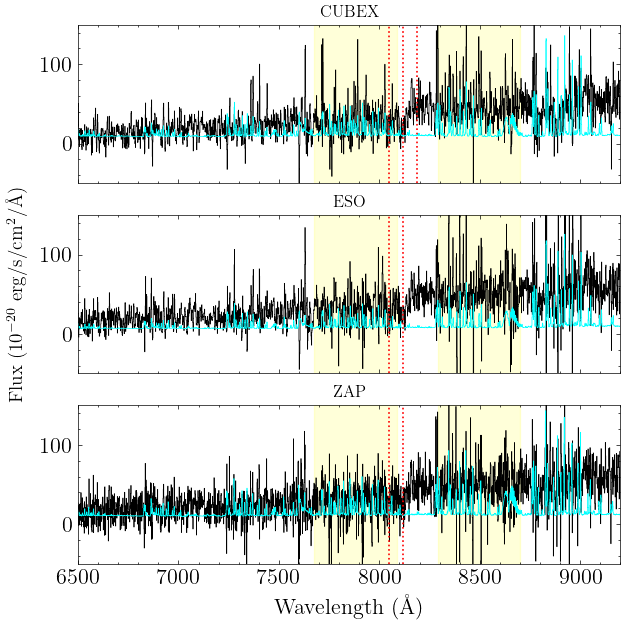

In [94]:
fig, axes = plt.subplots(3, 1, figsize=(7,7), sharex=True, sharey=True)

axes[0].step(wav_arr_cubex, spec_gal_cubex, where='mid', lw=.5)
axes[0].step(wav_arr_cubex, err_gal_cubex, where='mid', color='cyan', lw=.5)

axes[0].axvline(3934.78*(1+1.0449), linestyle=':', color='red', lw=1.2)
axes[0].axvline(3969.59*(1+1.0449), linestyle=':', color='red', lw=1.2)
axes[0].axvline(4000*(1+1.047), linestyle=':', color='red', lw=1.2)

axes[0].axvspan(3750*(1+1.047),3950*(1+1.047), color='yellow', alpha=.15)
axes[0].axvspan(4050*(1+1.047),4250*(1+1.047), color='yellow', alpha=.15)

axes[0].set_title('CUBEX', fontsize=12)

#axes[0].axhline(23, linestyle='--', color='orange')
#axes[0].axhline(42, linestyle='--', color='orange')

axes[0].set_xlim(6500, 9200)
#axes[0].set_ylim(-50, 150)
axes[0].set_ylim(-50,150)

axes[1].step(wav_arr_eso, spec_gal_eso, where='mid', lw=.5)
axes[1].step(wav_arr_eso, err_gal_eso, where='mid', color='cyan', lw=.5)

axes[1].axvline(3934.78*(1+1.0449), linestyle=':', color='red', lw=1.2)
axes[1].axvline(3969.59*(1+1.0449), linestyle=':', color='red', lw=1.2)

#axes[1].axvline(4000*(1+1.047), linestyle=':', color='red', lw=1.2)

axes[1].axvspan(3750*(1+1.047),3950*(1+1.047), color='yellow', alpha=.15)
axes[1].axvspan(4050*(1+1.047),4250*(1+1.047), color='yellow', alpha=.15)

#axes[1].axhline(23, linestyle='--', color='orange')
#axes[1].axhline(42, linestyle='--', color='orange')
axes[1].set_title('ESO', fontsize=12)
axes[1].set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

axes[2].step(wav_arr_zap, spec_gal_zap, where='mid', lw=.5)
axes[2].step(wav_arr_zap, err_gal_zap, where='mid', color='cyan', lw=.5)

axes[2].axvline(3934.78*(1+1.0449), linestyle=':', color='red', lw=1.2)
axes[2].axvline(3969.59*(1+1.0449), linestyle=':', color='red', lw=1.2)

#axes[2].axvline(4000*(1+1.047), linestyle=':', color='red', lw=1.2)

axes[2].axvspan(3750*(1+1.047),3950*(1+1.047), color='yellow', alpha=.15)
axes[2].axvspan(4050*(1+1.047),4250*(1+1.047), color='yellow', alpha=.15)

#axes[2].axhline(23, linestyle='--', color='orange')
#axes[2].axhline(42, linestyle='--', color='orange')

axes[2].set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.

axes[2].set_title('ZAP', fontsize=12)

Text(0.5, 1.0, 'ZAP')

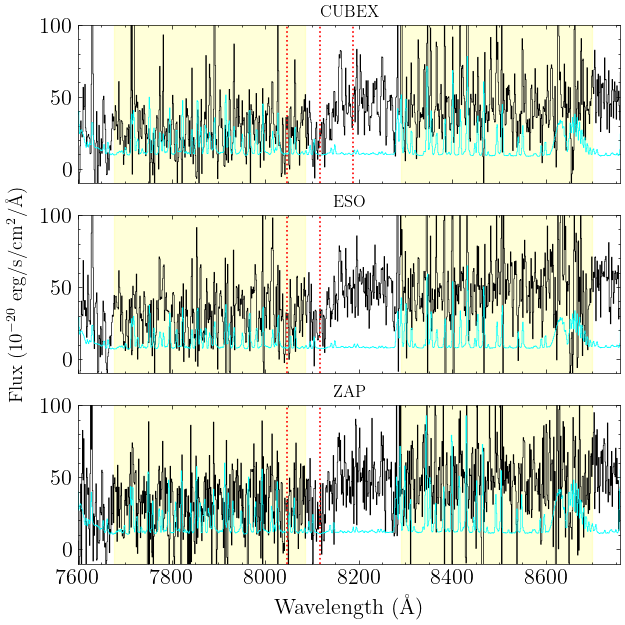

In [95]:
fig, axes = plt.subplots(3, 1, figsize=(7,7), sharex=True, sharey=True)

axes[0].step(wav_arr_cubex, spec_gal_cubex, where='mid', lw=.5)
axes[0].step(wav_arr_cubex, err_gal_cubex, where='mid', color='cyan', lw=.5)

axes[0].axvline(3934.78*(1+1.0449), linestyle=':', color='red', lw=1.2)
axes[0].axvline(3969.59*(1+1.0449), linestyle=':', color='red', lw=1.2)
axes[0].axvline(4000*(1+1.047), linestyle=':', color='red', lw=1.2)

axes[0].axvspan(3750*(1+1.047),3950*(1+1.047), color='yellow', alpha=.15)
axes[0].axvspan(4050*(1+1.047),4250*(1+1.047), color='yellow', alpha=.15)

axes[0].set_title('CUBEX', fontsize=12)

#axes[0].axhline(23, linestyle='--', color='orange')
#axes[0].axhline(42, linestyle='--', color='orange')

axes[0].set_xlim(7600, 8760)
#axes[0].set_ylim(-50, 150)
axes[0].set_ylim(-50,150)

axes[1].step(wav_arr_eso, spec_gal_eso, where='mid', lw=.5)
axes[1].step(wav_arr_eso, err_gal_eso, where='mid', color='cyan', lw=.5)

axes[1].axvline(3934.78*(1+1.0449), linestyle=':', color='red', lw=1.2)
axes[1].axvline(3969.59*(1+1.0449), linestyle=':', color='red', lw=1.2)

#axes[1].axvline(4000*(1+1.047), linestyle=':', color='red', lw=1.2)

axes[1].axvspan(3750*(1+1.047),3950*(1+1.047), color='yellow', alpha=.15)
axes[1].axvspan(4050*(1+1.047),4250*(1+1.047), color='yellow', alpha=.15)

#axes[1].axhline(23, linestyle='--', color='orange')
#axes[1].axhline(42, linestyle='--', color='orange')
axes[1].set_title('ESO', fontsize=12)
axes[1].set_xlim(7600, 8760)
axes[1].set_ylim(-10,100)
axes[1].set_ylabel(r'Flux ($10^{-20}$ erg/s/cm${}^2$/Å)', fontsize=14, labelpad=10)

axes[2].step(wav_arr_zap, spec_gal_zap, where='mid', lw=.5)
axes[2].step(wav_arr_zap, err_gal_zap, where='mid', color='cyan', lw=.5)

axes[2].axvline(3934.78*(1+1.0449), linestyle=':', color='red', lw=1.2)
axes[2].axvline(3969.59*(1+1.0449), linestyle=':', color='red', lw=1.2)

#axes[2].axvline(4000*(1+1.047), linestyle=':', color='red', lw=1.2)

axes[2].axvspan(3750*(1+1.047),3950*(1+1.047), color='yellow', alpha=.15)
axes[2].axvspan(4050*(1+1.047),4250*(1+1.047), color='yellow', alpha=.15)

#axes[2].axhline(23, linestyle='--', color='orange')
#axes[2].axhline(42, linestyle='--', color='orange')

axes[2].set_xlim(7600, 8760)
axes[2].set_ylim(-10,100)
axes[2].set_xlabel('Wavelength (Å)', labelpad=5) # Use argument `labelpad` to move label downwards.

axes[2].set_title('ZAP', fontsize=12)

Text(0, 0.5, '$f_\\lambda \\ \\mathrm{(1e-20 \\ erg/cm^2/s/Å)}$')

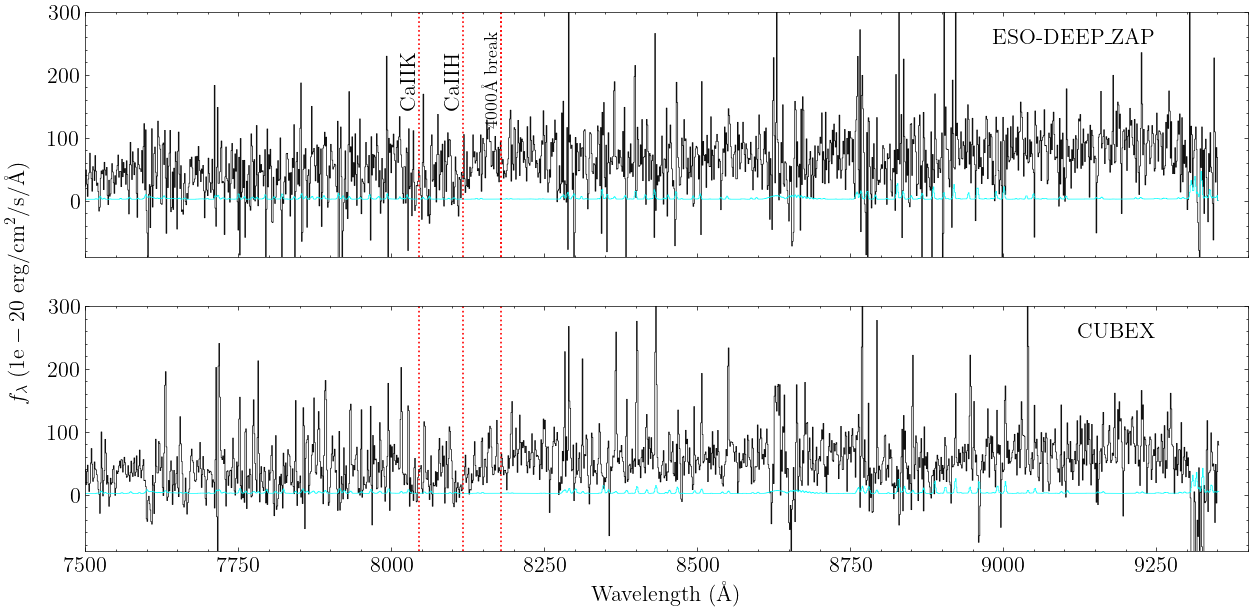

In [113]:
fig, axes = plt.subplots(2, 1, figsize=(15,7), sharex=True, sharey=True)


axes[0].step(wav_arr_eso, spec_gal_eso, where='mid', lw=.5)
axes[0].step(wav_arr_eso, err_gal_eso, where='mid', color='cyan', lw=.5)


axes[0].axvline(3934.78*(1+1.0448), linestyle=':', color='red', lw=1.2)
axes[0].text(3934.78*(1+1.0448), 150, 'CaIIK', rotation=90, horizontalalignment='right')
axes[0].axvline(3969.59*(1+1.0448), linestyle=':', color='red', lw=1.2)
axes[0].text(3969.59*(1+1.0448), 150, 'CaIIH', rotation=90, horizontalalignment='right')
axes[0].axvline(4000*(1+1.0448), linestyle=':', color='red', lw=1.2)
axes[0].text(4000*(1+1.0448), 120, '4000Å break', rotation=90, horizontalalignment='right', fontsize=13)


axes[0].axvline(4000*(1+1.0448), linestyle=':', color='red', lw=1.2)

axes[0].set_xlim(7500, 9400)
axes[0].set_ylim(-90, 300)

axes[0].text(9250, 250, 'ESO-DEEP_ZAP', horizontalalignment='right')

axes[1].step(wav_arr_cubex, spec_gal_cubex, where='mid', lw=.5)
axes[1].step(wav_arr_cubex, err_gal_cubex, where='mid', color='cyan', lw=.5)

axes[1].axvline(3934.78*(1+1.0448), linestyle=':', color='red', lw=1.2)
axes[1].axvline(3969.59*(1+1.0448), linestyle=':', color='red', lw=1.2)
axes[1].axvline(4000*(1+1.0448), linestyle=':', color='red', lw=1.2)

axes[1].text(9250, 250, 'CUBEX', horizontalalignment='right')

axes[1].set_xlabel('Wavelength (Å)')

ax_label = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
ax_label.set_xticks([])
ax_label.set_yticks([])

ax_label.set_ylabel(r'$f_\lambda \ \mathrm{(1e-20 \ erg/cm^2/s/Å)}$', labelpad=40) # Use argument `labelpad` to move label downwards.